<img src="../_resources/mgnify_logo.png" width="200px">

# Cross-Study analysis, using MGnifyR

The [MGnify API](https://www.ebi.ac.uk/metagenomics/api/v1) returns data and relationships as JSON. 
[MGnifyR](https://github.com/beadyallen/MGnifyR) is a package to help you read MGnify data into your R analyses.

**This example shows you how to perform an analysis across multiple Studies**

You can find all of the other "API endpoints" using the [Browsable API interface in your web browser](https://www.ebi.ac.uk/metagenomics/api/v1).

This is an interactive code notebook (a Jupyter Notebook).
To run this code, click into each cell and press the ▶ button in the top toolbar, or press `shift+enter`.

---

In [1]:
library(vegan)
library(ggplot2)
library(phyloseq)
library(MGnifyR)

mg <- mgnify_client(usecache = T, cache_dir = '/tmp/mgnify_cache')

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7



In [3]:
panama <- mgnify_analyses_from_studies(mg, 'MGYS00003920')
malaysia <- mgnify_analyses_from_studies(mg, 'MGYS00003918')

  |======================================================================| 100%
  |======================================================================| 100%


In [4]:
accessions <- c(panama, malaysia)

In [5]:
metadata <- mgnify_get_analyses_metadata(mg, accessions)
head(metadata)

  |======================================================================| 100%


,analysis_experiment-type,analysis_analysis-status,analysis_accession,analysis_pipeline-version,analysis_complete-time,analysis_instrument-platform,analysis_instrument-model,analysis_Submitted nucleotide sequences,analysis_Nucleotide sequences after format-specific filtering,analysis_Nucleotide sequences after length filtering,⋯,sample_depth,sample_elevation,sample_pH,sample_geographic location (latitude),sample_instrument model,sample_ENA checklist,sample_last update date,sample_acc_type,run_accession,biome_string
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MGYA00329605,unknown,completed,MGYA00329605,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,120,120,118,⋯,0.0-0.2,53.0,3.3,8.971447,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844693,root:Environmental:Terrestrial:Soil
MGYA00329606,unknown,completed,MGYA00329606,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,27607,27607,27233,⋯,0.0-0.2,120.0,6.4,9.1442795,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844694,root:Environmental:Terrestrial:Soil
MGYA00329607,unknown,completed,MGYA00329607,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,25238,25238,24806,⋯,0.0-0.2,120.0,5.6,9.1442795,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844695,root:Environmental:Terrestrial:Soil
MGYA00329608,unknown,completed,MGYA00329608,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,5,5,5,⋯,0.0-0.2,53.0,3.6,8.971447,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844696,root:Environmental:Terrestrial:Soil
MGYA00329609,unknown,completed,MGYA00329609,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,20805,20805,20464,⋯,0.0-0.2,155.0,6.9,9.080094,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844697,root:Environmental:Terrestrial:Soil
MGYA00329610,unknown,completed,MGYA00329610,4.1,2019-03-06T00:00:00,ILLUMINA,Illumina MiSeq,21171,21171,20834,⋯,0.0-0.2,64.0,6.3,8.908218,Illumina MiSeq,ERC000011,2017-02-18,samples,ERR1844698,root:Environmental:Terrestrial:Soil


In [6]:
goterms <-  mgnify_get_analyses_results(mg, accessions, retrievelist = "go-slim")$`go-slim`

  |===                                                                   |   4%

Warning message:
“Unknown or uninitialised column: `index_id`.”


  |=================================================                     |  71%

Warning message:
“Unknown or uninitialised column: `index_id`.”


  |======================================================================| 100%


In [10]:
m <- goterms[,c(-1,-2,-3)]  # goterms dataframe, but without the first 3 (text) columns
normed_m <- apply(m, 2, function(x) x/sum(x))

In [24]:
goterms

accession,description,lineage,MGYA00329544,MGYA00329545,MGYA00329546,MGYA00329547,MGYA00329548,MGYA00329549,MGYA00329550,⋯,MGYA00329638,MGYA00329639,MGYA00329640,MGYA00329641,MGYA00329642,MGYA00329643,MGYA00329644,MGYA00329645,MGYA00329646,MGYA00329647
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
GO:0000015,phosphopyruvate hydratase complex,cellular_component,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GO:0000150,recombinase activity,molecular_function,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GO:0000160,phosphorelay signal transduction system,biological_process,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GO:0000166,nucleotide binding,molecular_function,0,0,0,0,1,0,0,⋯,1,0,0,0,0,0,0,0,1,0
GO:0003674,molecular function,molecular_function,51,53,40,53,50,48,34,⋯,61,67,53,61,58,66,48,78,83,51
GO:0003676,nucleic acid binding,molecular_function,2,2,2,5,0,6,4,⋯,3,7,2,7,2,3,1,2,9,2
GO:0003700,"transcription factor activity, sequence-specific DNA binding",molecular_function,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GO:0003735,structural constituent of ribosome,molecular_function,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GO:0003824,catalytic activity,molecular_function,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,1,0


In [11]:
nmds <- vegan::metaMDS(t(normed_m))

Run 0 stress 9.785666e-05 
Run 1 stress 9.30902e-05 
... New best solution
... Procrustes: rmse 7.2625e-05  max resid 0.0002627188 
... Similar to previous best
Run 2 stress 8.277434e-05 
... New best solution
... Procrustes: rmse 5.985889e-05  max resid 0.0001676536 
... Similar to previous best
Run 3 stress 9.335508e-05 
... Procrustes: rmse 6.839006e-05  max resid 0.0001891973 
... Similar to previous best
Run 4 stress 6.925387e-05 
... New best solution
... Procrustes: rmse 2.831951e-05  max resid 9.060113e-05 
... Similar to previous best
Run 5 stress 9.357436e-05 
... Procrustes: rmse 6.146245e-05  max resid 0.0001612214 
... Similar to previous best
Run 6 stress 9.832111e-05 
... Procrustes: rmse 6.675951e-05  max resid 0.0001993689 
... Similar to previous best
Run 7 stress 3.180503e-05 
... New best solution
... Procrustes: rmse 1.951433e-05  max resid 4.885076e-05 
... Similar to previous best
Run 8 stress 8.762877e-05 
... Procrustes: rmse 2.559e-05  max resid 6.382883e-05 


Warning message in vegan::metaMDS(t(normed_m)):
“stress is (nearly) zero: you may have insufficient data”


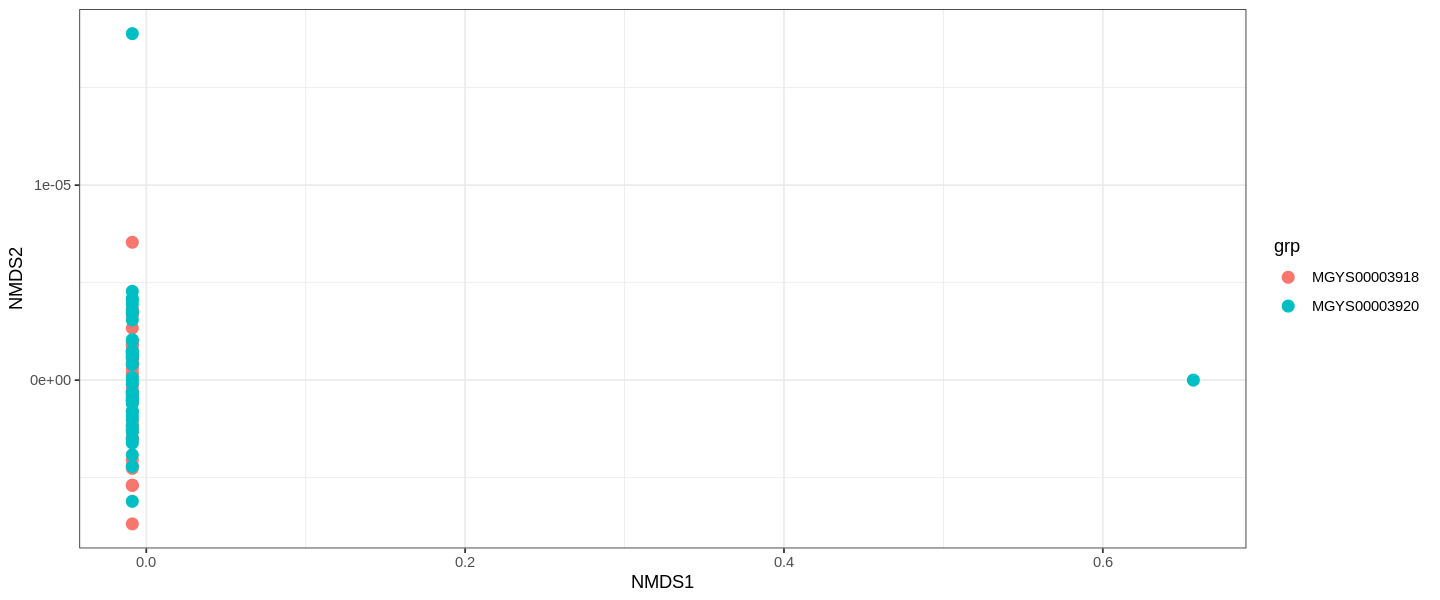

In [18]:
pltdat <- as.data.frame(scores(nmds))
pltdat$grp <- metadata[rownames(pltdat),"study_accession"]  #  add the grp variable created earlier

options(repr.plot.width=12, repr.plot.height=5)
ggplot() + geom_point(data=pltdat,aes(x=NMDS1,y=NMDS2,colour=grp),size=3) + theme_bw()